# Constrained sinusoidal models
> Applying the complex surrogate to models where sinusoidal frequencies are related or constrained

In [ ]:
#| default_exp constrained_model

In [ ]:
from functools import partial
import math

import IPython.display as ipd
from lapsolver import solve_dense
import matplotlib.pyplot as plt
import torch
from torch import nn

from sinusoidal_gradient_descent.core import fft_loss

In [ ]:
class HarmonicModel(nn.Module):
    def __init__(self, n_harmonics):
        super().__init__()
        self.n_harmonics = n_harmonics
        self.register_buffer("k", torch.arange(1, n_harmonics + 1))
        self.amp = nn.Parameter(torch.rand(n_harmonics))
        self.r = nn.Parameter(torch.ones(n_harmonics))
        # self.f0 = nn.Parameter(torch.exp(1j * torch.rand(1) * math.pi / n_harmonics))
        self.f0 = nn.Parameter(torch.rand(1) * math.pi / n_harmonics)

    def forward(self, n):
        freqs = self.r * torch.exp(1j * self.k * self.f0)
        harmonics = (
            self.amp[:, None]
            * (freqs.abs()[:, None] ** n[..., None, :])
            * torch.cos(freqs.angle()[:, None] * n[..., None, :])
        )
        # harmonics = (
        #     self.amp[:, None]
        #     * (self.f0.abs() ** n[..., None, :])
        #     * torch.cos(self.f0.angle() * self.k[:, None] * n[..., None, :])
        # )
        return torch.sum(harmonics, dim=-2)
    
    @property
    def freq(self):
        return self.f0 * self.k


[<matplotlib.lines.Line2D>]

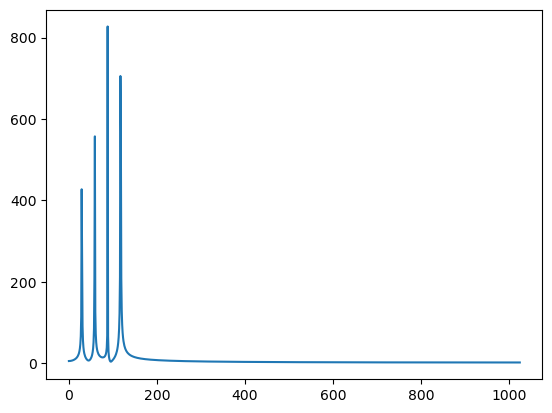

In [ ]:
model = HarmonicModel(4)
plt.plot(torch.fft.rfft(model(torch.arange(2048)).detach()).abs())

In [ ]:
class SinusoidalModel(nn.Module):
    def __init__(self, n_sinusoids):
        super().__init__()
        self.n_sinusoids = n_sinusoids
        self.amp = nn.Parameter(torch.rand(n_sinusoids))
        self.freq = nn.Parameter(torch.exp(1j * torch.rand(n_sinusoids) * math.pi))
    
    def forward(self, n):
        return torch.sum(self.amp[:, None] * (self.freq[:, None] ** n[..., None, :]).real, dim=-2)

[<matplotlib.lines.Line2D>]

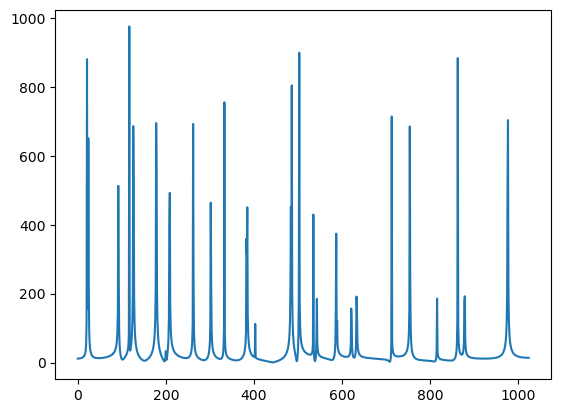

In [ ]:
model = SinusoidalModel(32)
plt.plot(torch.fft.rfft(model(torch.arange(2048)).detach()).abs())

In [ ]:
def min_lap_cost(x, y, p, q):
    cost = torch.cdist(x[..., None], y[..., None], p=2)
    pq_cost = torch.cdist(p[..., None], q[..., None], p=2)
    assignment = solve_dense(cost.detach().numpy())
    return torch.mean(cost[assignment] * q) + torch.mean(pq_cost[assignment])

In [ ]:
torch.manual_seed(0)

N = 4096
n = torch.arange(N)
n_harmonics = 16

[<matplotlib.lines.Line2D>]

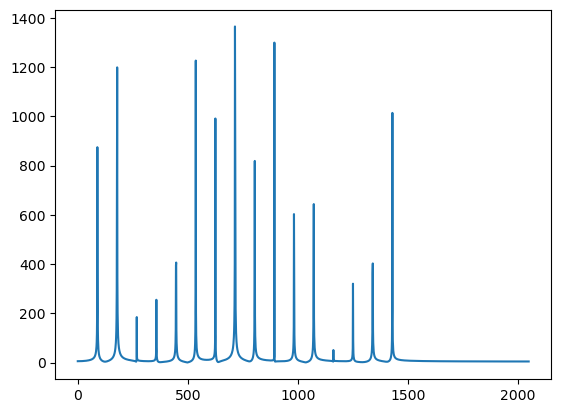

In [ ]:
target_model = HarmonicModel(n_harmonics).requires_grad_(False)
target_signal = target_model(n)
plt.plot(torch.fft.rfft(target_signal).abs())

In [ ]:
model = HarmonicModel(n_harmonics)
sinusoidal_model = SinusoidalModel(n_harmonics)
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(sinusoidal_model.parameters()), lr=1e-4
)
loss_fn = partial(fft_loss, lin_l1=0.0, lin_huber=1.0, huber_delta=1.00)


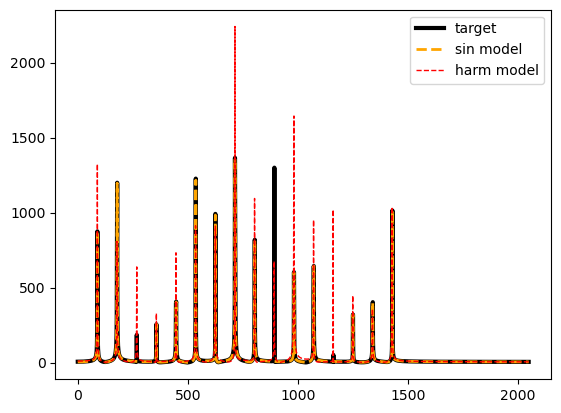

KeyboardInterrupt: 

In [ ]:
steps = 100000

losses = []
for step in range(steps):
    optimizer.zero_grad()
    signal = sinusoidal_model(n)
    harm_signal = model(n)
    sig_loss = loss_fn(signal, target_signal)
    lap_loss = min_lap_cost(model.freq, sinusoidal_model.freq.angle().detach(), model.amp, sinusoidal_model.amp.detach())
    loss = sig_loss + lap_loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if step % 500 == 0:
        with torch.no_grad():
            plt.plot(torch.fft.rfft(target_signal).abs(), color="black", label="target", linewidth=3)
            plt.plot(torch.fft.rfft(sinusoidal_model(n)).abs(), "--", color="orange", label="sin model", linewidth=2)
            plt.plot(torch.fft.rfft(model(n)).abs(), "--", color="red", label="harm model", linewidth=1)
            plt.legend()

            ipd.clear_output()
            plt.show()
    if step % 50 == 0:
        print(f"Step {step}: {loss.item()}", end="\r")

In [ ]:
torch.arange(1, n_harmonics + 1) * model.f0

tensor([0.1369, 0.2739, 0.4108, 0.5478, 0.6847, 0.8217, 0.9586, 1.0955, 1.2325,
        1.3694, 1.5064, 1.6433, 1.7802, 1.9172, 2.0541, 2.1911],
       grad_fn=<MulBackward0>)

In [ ]:
torch.arange(1, n_harmonics + 1) * target_model.f0

tensor([0.1370, 0.2740, 0.4110, 0.5479, 0.6849, 0.8219, 0.9589, 1.0959, 1.2329,
        1.3699, 1.5069, 1.6438, 1.7808, 1.9178, 2.0548, 2.1918])